# Laboratorio #6 – Análisis de tráfico de red

# Librerías

In [ ]:
import pandas as pd
import binascii
import numpy as np
import matplotlib.pyplot as plt
from scapy.all import *

# Análisis estadístico

## 1. Descargue e archivo analisis_paquetes.pcap y asignelo a una variable.

In [2]:
pcap_p = rdpcap("analisis_paquetes.pcap")

In [3]:
pcap_p[0].show()

###[ Ethernet ]###
  dst       = 80:37:73:96:9b:db
  src       = 88:e9:fe:6a:92:52
  type      = IPv4
###[ IP ]###
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 961
     id        = 1
     flags     = 
     frag      = 0
     ttl       = 64
     proto     = udp
     chksum    = 0x52e6
     src       = 10.1.10.53
     dst       = 84.54.22.33
     \options   \
###[ UDP ]###
        sport     = domain
        dport     = domain
        len       = 941
        chksum    = 0xf60e
###[ DNS ]###
           id        = 12
           qr        = 0
           opcode    = QUERY
           aa        = 0
           tc        = 0
           rd        = 1
           ra        = 0
           z         = 0
           ad        = 0
           cd        = 0
           rcode     = ok
           qdcount   = 1
           ancount   = 0
           nscount   = 0
           arcount   = 0
           \qd        \
            |###[ DNS Question Record ]###
            |  qname     = b

## 2. Convierta la variable a un DataFrame.

In [4]:
# Codigo extraido de https://github.com/AnthonyCamper/pcap_scraping/blob/master/data_extract.py
def extract(ourpcap):
    ip_fields = [field.name for field in IP().fields_desc]
    tcp_fields = [field.name for field in TCP().fields_desc]
    udp_fields = [field.name for field in UDP().fields_desc]

    dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

    df = pd.DataFrame(columns=dataframe_fields)
    for packet in ourpcap[IP]:
        # Field array for each row of DataFrame
        field_values = []
        # Add all IP fields to dataframe
        for field in ip_fields:
            if field == 'options':
                # Retrieving number of options defined in IP Header
                field_values.append(len(packet[IP].fields[field]))
            else:
                field_values.append(packet[IP].fields[field])
        
        field_values.append(packet.time)
        
        layer_type = type(packet[IP].payload)
        for field in tcp_fields:
            try:
                if field == 'options':
                    field_values.append(len(packet[layer_type].fields[field]))
                else:
                    field_values.append(packet[layer_type].fields[field])
            except:
                field_values.append(None)
        
        # Append payload
        field_values.append(len(packet[layer_type].payload))
        field_values.append(packet[layer_type].payload.original)
        field_values.append(binascii.hexlify(packet[layer_type].payload.original))
        # Add row to DF
        df_append = pd.DataFrame([field_values], columns=dataframe_fields)
        df = pd.concat([df, df_append], axis=0)
        df = df.reset_index()
        # Drop old index column
        df = df.drop(columns="index")

    return df

In [5]:
dataframe = extract(pcap_p)

## 3. Muestre el contenido de las primeras 5 filas del dataset.

In [6]:
dataframe.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,4,5,32,84,58919,,0,122,17,13836,...,None,None,None,None,65061,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,4,5,32,84,59493,,0,122,17,13262,...,None,None,None,None,65063,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [7]:
dataframe.shape

(62, 28)

## 4. Muestre los valores de las columnas: Src Addres, Dst Address, Src Port y Dst Port.

In [9]:
dataframe[["src", "dst", "sport", "dport"]]

,src,dst,sport,dport
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53
...,...,...,...,...
57,84.54.22.33,10.1.10.53,53,53
58,10.1.10.53,84.54.22.33,53,53
59,84.54.22.33,10.1.10.53,53,53
60,10.1.10.53,84.54.22.33,53,53


## 5. Estadísticas

### a. Muestre todas las IP origen

In [11]:
dataframe.src.unique()

array(['10.1.10.53', '84.54.22.33', '75.75.75.75'], dtype=object)

### b. Muestre todas las IP destino

In [12]:
dataframe.dst.unique()

array(['84.54.22.33', '10.1.10.53', '75.75.75.75'], dtype=object)

### c. ¿Cuál es la IP origen más frecuente?

In [13]:
dataframe.src.value_counts()

src
10.1.10.53     31
84.54.22.33    29
75.75.75.75     2
Name: count, dtype: int64

La IP origen más frecuente es la IP `10.1.10.53`

In [14]:
ipSrc = dataframe.src.value_counts().index[0]

#### i. ¿A qué IP destino se comunica con más frecuencia?

In [17]:
dataframe[dataframe["src"] == ipSrc].dst.value_counts()

dst
84.54.22.33    29
75.75.75.75     2
Name: count, dtype: int64

In [18]:
ipDst = dataframe[dataframe["src"] == ipSrc].dst.value_counts().index[0]

La IP origen `10.1.10.53` se ha comunicado con más frecuencia con la IP `84.54.22.33`

#### ii. ¿A que puerto destino se comunica? ¿Cuál es el propósito de este puerto?

In [20]:
dataframe[(dataframe["src"] == ipSrc) & (dataframe["dst"] == ipDst)].dport.value_counts()

dport
53    29
Name: count, dtype: int64

El puerto 53 es utilizado por el servicio Domain Name System (DNS). Dicho servicio es para la traducción de nombres de nominio (por ejemplo google.com) a direcciones IP numéricas (8.8.8.8), servicio necesario para localizar y acceder al sitio en cuestión. Este puerto utiliza dos protocolos, UDP para la mayoría de consultas (consultas rápidas) pero también puede llegar a utilizar TCP para consultas que requieren una mayor transferencia de datos que UPD no soporta.

[Referencia](https://books.spartan-cybersec.com/cppj/networking-for-juniors/puertos-y-servicios/puerto-53-dns)

#### iii. ¿Desde que puertos origen se comunica?

In [21]:
dataframe[(dataframe["src"] == ipSrc) & (dataframe["dst"] == ipDst)].sport.value_counts()

sport
53    29
Name: count, dtype: int64

Se comunica siempre del mismo puerto, el puerto 53.

## 6. Gráficas

### a. Genere una gráfica de barras 2D horizontales, en el eje Y las IPs origen, y en el eje X la suma de los payloads (bytes) enviados desde dichas direcciones

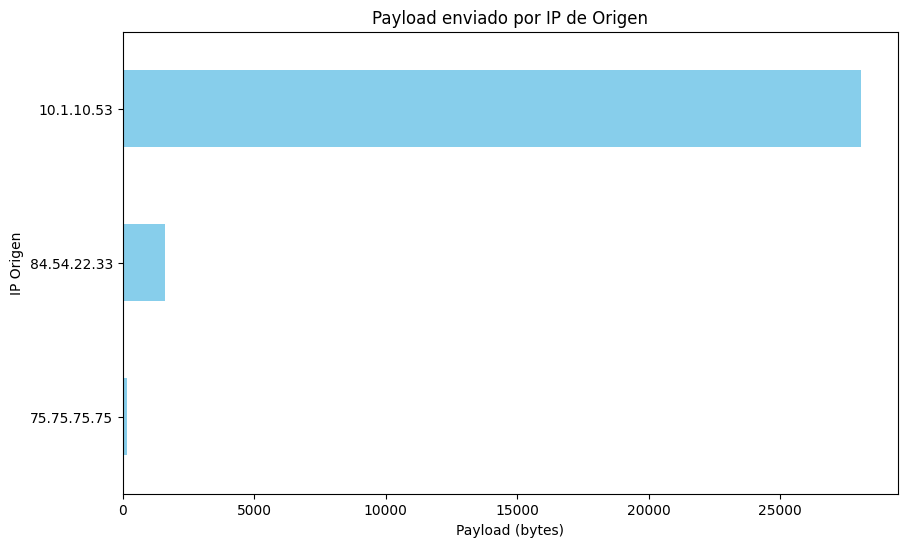

In [35]:
graph1 = dataframe.groupby("src").payload.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
graph1.plot(kind="barh", color="skyblue")
plt.xlabel("Payload (bytes)")
plt.ylabel("IP Origen")
plt.title("Payload enviado por IP de Origen")
plt.gca().invert_yaxis()
plt.show()

### b. Genere una gráfica de barras 2D horizontales, en el eje Y las IP destino, y en el eje X la suma de los payloads (bytes) recibidos en dichas direcciones

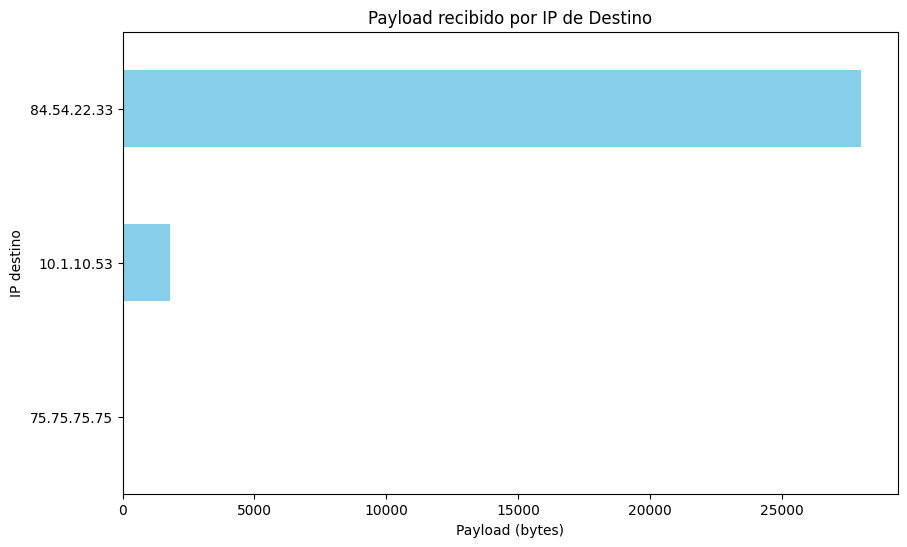

In [38]:
graph2 = dataframe.groupby("dst").payload.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
graph2.plot(kind="barh", color="skyblue")
plt.xlabel("Payload (bytes)")
plt.ylabel("IP destino")
plt.title("Payload recibido por IP de Destino")
plt.gca().invert_yaxis()
plt.show()

### c. Genere una gráfica de barras 2D horizontales, en el eje Y los puertos origen, y en el eje X la suma de los payloads (bytes) enviados de dichos puertos

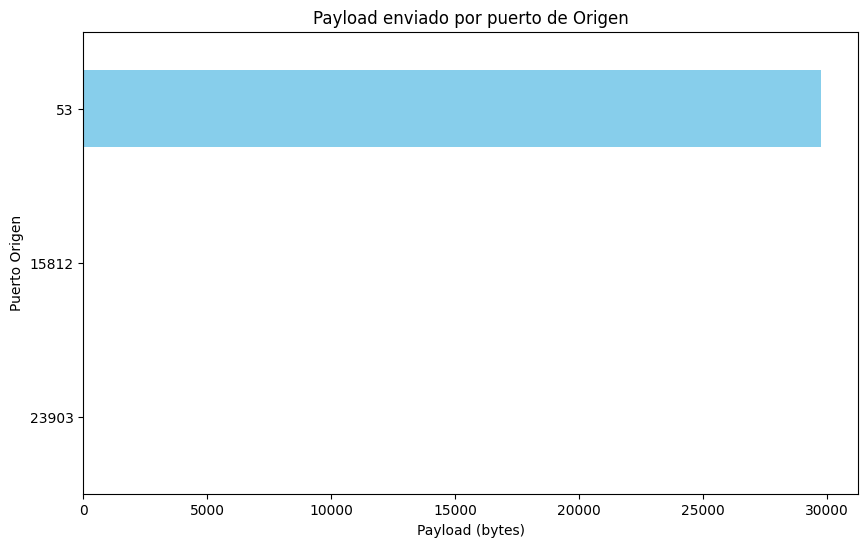

In [36]:
graph3 = dataframe.groupby("sport").payload.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
graph3.plot(kind="barh", color="skyblue")
plt.xlabel("Payload (bytes)")
plt.ylabel("Puerto Origen")
plt.title("Payload enviado por puerto de Origen")
plt.gca().invert_yaxis()
plt.show()

### d. Genere una gráfica 2D de barras horizontales, en el eje Y los puertos destino, y en el eje X la suma de los payloads (bytes) recibidos en dichos puertos.

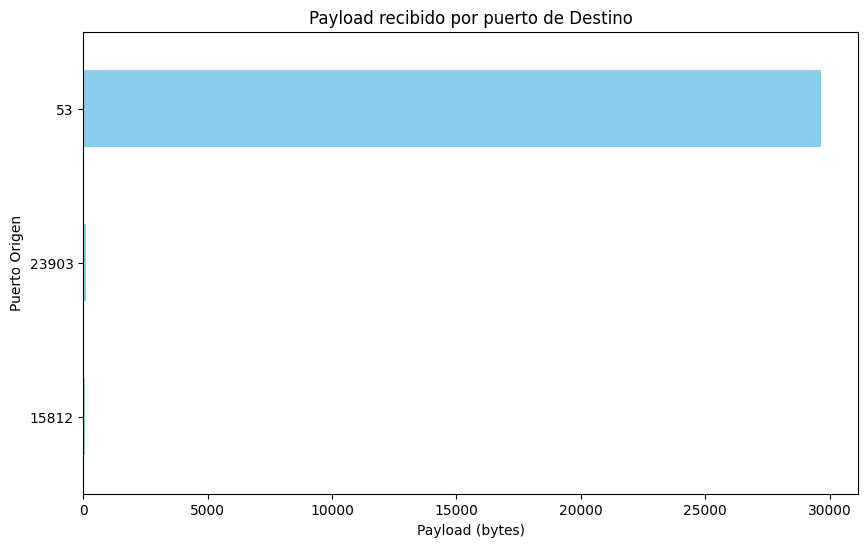

In [37]:
graph4 = dataframe.groupby("dport").payload.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
graph4.plot(kind="barh", color="skyblue")
plt.xlabel("Payload (bytes)")
plt.ylabel("Puerto Origen")
plt.title("Payload recibido por puerto de Destino")
plt.gca().invert_yaxis()
plt.show()

### e. Genere una gráfica de barras 2D verticales, en el eje Y la suma de los payload, en el eje X el tiempo, para la IP origen más frecuente.

In [ ]:
dataframe["time"] = pd.to_numeric(dataframe["time"], errors="coerce")
dataframe.time = pd.to_datetime(dataframe.time, unit='s')
dataframe["time"] = dataframe["time"].dt.strftime('%Y-%m-%d %H:%M:%S')

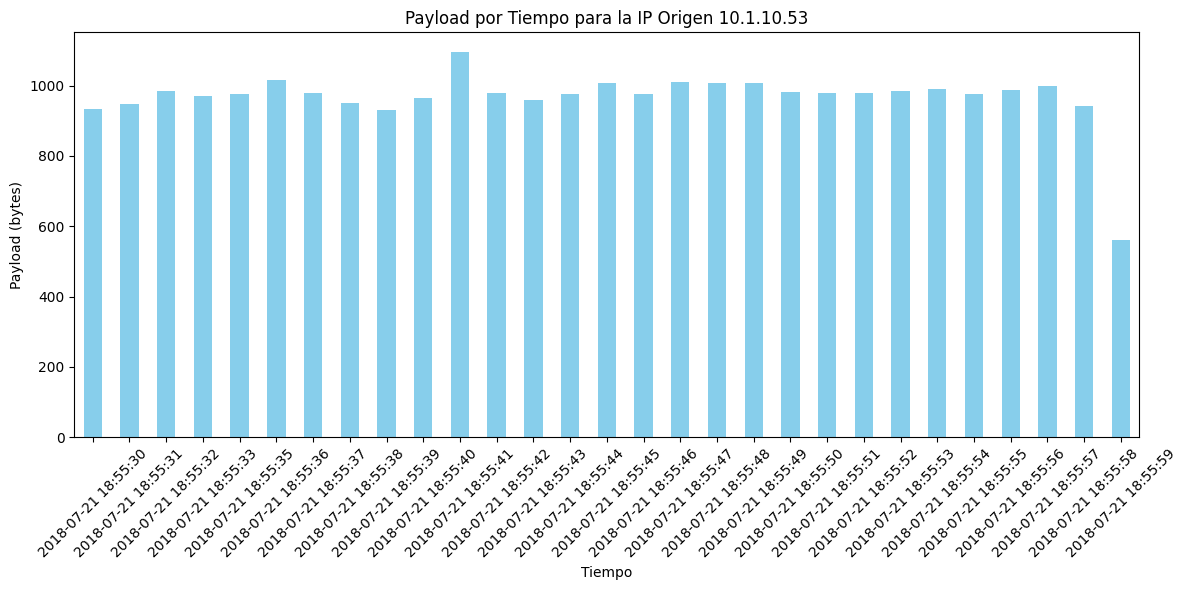

In [53]:
graph5 = dataframe[dataframe["src"] == ipSrc].groupby("time").payload.sum()
plt.figure(figsize=(12, 6))
graph5.plot(kind="bar", color="skyblue")
plt.xlabel("Tiempo")
plt.ylabel("Payload (bytes)")
plt.title(f"Payload por Tiempo para la IP Origen {ipSrc}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### f. Utilizando la información de las estadísticas y la información del comportamiento del tráfico que las gráficas muestran, describa que es lo que está sucediendo. ¿Es común el comportamiento?

No, no es común este comportamiento. Inicialmente, con los gráficos (a-d) que muestran los payload enviados/recibidos por las IPs/puertos no se observa algun comportamiento "raro", pero analizandolo bajo el tiempo sí se logra ver algo raro. Y es que se la IP origen `10.1.10.53` está enviando peticiones por segundo (más, ya que se aproximó la hora a HH:MM:SS antes tenían más cifras los segundos) y eso es un comportamiento curioso. No es normal que un usuario esté realizando peticiones en esa magnitud

## 7. Investigación del payload

### a. Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen más frecuente.

In [88]:
payloadDataframeDemo = dataframe[(dataframe.src == ipSrc) | (dataframe.dst == ipDst)]

In [77]:
payloadDataframeDemo.shape

(31, 28)

### b. Cree un nuevo DF que utilice el DF anterior con las columnas src, dst y payload y agrúpelas por dst y la suma del payload

In [89]:
payloadDataframe = payloadDataframeDemo[["src", "dst", "payload"]]
payloadDataframe = payloadDataframe.groupby("dst").payload.sum().reset_index()

In [86]:
payloadDataframe

,dst,payload
0,75.75.75.75,74
1,84.54.22.33,27979


### c. Obtenga la IP destino que más ha intercambiado bytes con la IP origen más frecuente. Esta IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.

In [94]:
payloadDataframe.sort_values(by="payload", ascending=False).head(1).dst

1    84.54.22.33
Name: dst, dtype: object

### d. Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.

In [106]:
finalDataframe = payloadDataframeDemo[(payloadDataframeDemo["src"] == ipSrc) & (payloadDataframeDemo["dst"] == ipDst)]
finalDataframe = finalDataframe[["src", "dst", "sport", "dport", "payload_raw", "payload_hex"]]
finalDataframe = finalDataframe.reset_index(drop=True)

In [107]:
finalDataframe

,src,dst,sport,dport,payload_raw,payload_hex
0,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
5,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
6,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
7,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
8,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
9,10.1.10.53,84.54.22.33,53,53,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


### e. Obtenga los payloads del DF del inciso anterior, y añada cada uno en un array.

In [110]:
payloads = finalDataframe.payload_hex.values

### f. Muestre el contenido del array.

In [113]:
payloads

array([b'000c0100000100000000000006676f6f676c6503636f6d00001c0001efbfbd504e470d0a1a0a0000000d4948445200000162000000efbfbd080600000028efbfbd545200003aefbfbd4944415478efbfbdefbfbd097c54efbfbdefbfbdefbfbdefbfbdefbfbd3b4b12083b08efbfbd0a45efbfbdefbfbd2419efbfbdefbfbd5a69dfaa2defbfbd3b4e32efbfbdefbfbd56efbfbd56efbfbd61efbfbd5a1121efbfbdefbfbd01dcbb696b5befbfbd2e6f6befbfbd65efbfbd015cefbfbdefbfbd5defbfbd2defbfbdefbfbdefbfbd64efbfbd08efbfbd08efbfbdefbfbd67efbfbdefbfbdefbfbd3cefbfbdefbfbd4c12efbfbd24337766efbfbdefbfbd023c5f0defbfbd59efbfbd72efbfbdefbfbd79efbfbdefbfbdefbfbd1c0d18efbfbd3863efbfbd65770d1eefbfbdefbfbdefbfbdefbfbd13efbfbd69614befbfbdefbfbdefbfbdefbfbd757dc5b277efbfbd64efbfbdefbfbd15efbfbd2260063a13efbfbd0befbfbd0c16efbfbd12efbfbd26efbfbd39c690efbfbd00efbfbdefbfbdefbfbd081131d28c5148502aefbfbd40044f34efbfbdefbfbdefbfbd373c79efbfbd0e2e39efbfbdefbfbdefbfbd61324061efbfbdefbfbd2622efbfbd1311efbfbd63efbfbd6b4fefbfbd7340efbfbd39efbfbd69efbfbd3458efbfbd78efbfbd4befbfbd612166efbfbdefbfbd307

### g. Observe los primeros bytes del contenido,

In [116]:
payloadsText = [bytes.fromhex(payload.decode()).decode('utf-8', errors='ignore') for payload in payloads]

In [117]:
payloadsText

['\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01�PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00�\x08\x06\x00\x00\x00(�TR\x00\x00:�IDATx��\t|T�����;K\x12\x08;\x08�\nE��$\x19��Ziߪ-�;N2��V�V�a�Z\x11!��\x01ܻik[�.ok�e�\x01\\��]�-���d�\x08�\x08��g���<��L\x12�$3wf��\x02<_\r�Y�r��y���\x1c\r\x18�8c�ew\r\x1e����\x13�iaK����u}Ųw�d��\x15�"`\x06:\x13�\x0b�\x0c\x16�\x12�&�9Ɛ�\x00���\x08\x111ҌQHP*�@\x04O4���7<y�\x0e.9���a2@a��&"�\x13\x11�c�kO�s@�9�i�4X�x�K�a!f��0w��3dx\x1d"���C(�}�0|q�*��\x0b�a!f�4��.�sKg\x10\x11]=9NԂ\x06��u���K_�e\x06*���\x19Px��%��\x03�3��\x1e"E?\x0f���+H�]Q�k����8�"�\x1d\x114v�2\x10���咯̸|�x.\\�-b�I�B���@�L��CJ]XWQ����uQ�kQ\x13\x7f�N�1\x00���2\x17�03\x10�\\\x04�@!�H�BJqG\'+�R�U\\[����GXC;��Ԏ�q�!\x04�r�s=�\x02rԴ\x0b���_S�%�ph�a\x12Y\x05\x02����c���P�9�',
 '\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01:�le:ǩ���\x0c���:|\x11�X��q.e���a\x120�J}4\n9$vz�R�uO/��;ǫ]��M"�rTӣH1i��˥Ͱ\x103L<k�\x01_\x07R\x1

### ¿encuentra algún tipo de dato que no haga sentido que se envíe al puerto destino? Describa lo que encontró.

Sí, en el primer paquete se observa que su payload incluye una PNG. Lo cuál es realmente inusual, ya que al tratarse de un puerto destino que tiene como función aportar el servicio DNS no hace sentido que se le envíe un archivo PNG.
Aunque se tratara de una violación de seguridad, el enviar una imagen por este puerto no es tan usual para el hacking; pero el escenario podría describirse como un Tunel DNS, donde se busca el enviar/recibir datos (podría ser implantación de malware o bien un robo de información como una exfiltración de datos) utilizando consultas DNS para así evitar que la mayoría de firewalls detecten la anomalía. 

[Referencia 1](https://www.cloudflare.com/es-es/learning/dns/dns-security/)

[Referencia 2](https://www.akamai.com/es/glossary/what-is-dns-tunneling#:~:text=El%20túnel%20DLS%20es%20un,como%20transporte%20de%20tráfico%20malicioso.)